#Imports


In [ ]:
from google.colab import files
import pandas as pd
import io
from sklearn import preprocessing 
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn import tree
import numpy as np

from sklearn import neighbors


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#Funciones

In [ ]:
def clean_df(df, index, exclude, remove_goalkeepers, remove_suplentes, remove_president_cup, remove_cpv, remove_time_scoring, remove_group_phase):
  
  df = df.loc[:, df.columns.difference(exclude)]

  if remove_president_cup:
    df = df.drop(df.query("Phase == 'President Cup'").index)

  if remove_cpv:
    df = df.drop(df.query("Team == 'CPV'").index)

  if remove_group_phase:
    df = df.drop(df.query("Phase == 'Group Phase'").index)

  df = df.set_index(index)

  df = df.groupby([index]).sum()

  if remove_goalkeepers:
    df = df.drop(df.query("scoring == 0.0 & Time != 0.0").index)

  if remove_suplentes:
    df = df.drop(df.query("Time == 0.0").index)

  exclude = ['Phase']

  if index == 'Name':
    exclude.append('Team')
  elif index == 'Team':
    exclude.append('Name')

  if remove_time_scoring:
    exclude.append('Time')
    exclude.append('scoring')

  df = df.loc[:, df.columns.difference(exclude)]

  return df


def sumatorio_goals_missed(df):
  df['sum_goles'] = df['7mGoals'] + df['6mGoals'] + df['WingGoals'] + df['BTGoals'] + df['FBGoals'] + df['EGGoals'] + df['9mGoals'] 
  df['sum_missed'] = df['7mMissed'] + df['6mMissed'] + df['WingMissed'] + df['BTMissed'] + df['FBMissed'] + df['EGMissed'] + df['9mMissed'] 

  exclude = ['7mGoals', '7mMissed', '6mGoals', '6mMissed', 'WingGoals', 'WingMissed', 'BTGoals', 'BTMissed', 'FBGoals', 'FBMissed', 'EGGoals', 'EGMissed', '9mGoals', '9mMissed']
  df = df.loc[:, df.columns.difference(exclude)]
  return df

def find_best_max_depth(x_train, y_train, x_test, y_test):  
  maes = []
  
  for profundidad in range(1, 30):
      arbol = tree.DecisionTreeClassifier(max_depth=profundidad, criterion='entropy')
      
      arbol.fit(x_train, y_train)
      
      y_pred = arbol.predict(x_test)
      
      mae = mean_absolute_error(y_test, y_pred)

      maes.append(mae)
  plt.plot(range(1,len(maes)+1), maes, marker='o')
  print ('Min Value : ' +  str(min(maes)) +" (" + str(np.argmin(maes) + 1) + ")")
  plt.ylabel('MAE')      
  plt.show()

def find_best_parameters_KNN(x_train, y_train, x_test, y_test):
  cv = KFold(n_splits = 10, shuffle = False) 
  for p in [1,2]:
    if p==1:
          print('Manhattan Distance\n')
    else:
          print('Euclidean Distance\n')
    for i, weights in enumerate(['uniform', 'distance']):
      total_scores = []
      for n_neighbors in range(1,35):
          knn = neighbors.KNeighborsClassifier(n_neighbors, weights=weights,p=p)
          knn.fit( X = x_train, y = y_train)
          y_pred = knn.predict(X = x_test)
          mae = mean_absolute_error(y_test, y_pred)
          total_scores.append(mae)
      
      plt.plot(range(1,len(total_scores)+1), total_scores, 
                marker='o', label=weights)
      

      print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
      plt.ylabel('MAE')      
        

    plt.legend()
    plt.show()

def merge_df_stats_results(df_stats, df_results):
  partidos_con_estadisticas = []

  for i, partido in df_results.iterrows():
      
      estadisticas_local = df_stats[df_stats.index == partido['Equipo_local']].copy()
      estadisticas_local['Index']=i

      estadisticas_visitante = df_stats[df_stats.index == partido['Equipo_visitante']].copy()
      estadisticas_visitante['Index']=i

      partido_con_estadisticas = pd.merge(estadisticas_local, estadisticas_visitante, on="Index")

      partido_con_estadisticas.drop('Index', axis=1, inplace=True)
      
      partidos_con_estadisticas.append(partido_con_estadisticas)

  df_partidos_con_estadisticas = pd.concat(partidos_con_estadisticas, ignore_index=True)

  df_prediccion = pd.merge(df_results, df_partidos_con_estadisticas,left_index=True, right_index=True)

  x = df_prediccion.drop(['Equipo_local', 'Equipo_visitante', 'Resultado'], axis=1)
  y = df_prediccion['Resultado']

  return x, y


def predict_result(df, team1, team2, model, red_neuronal):
  equipo_1 = df[df.index == team1].copy()
  equipo_2 = df[df.index == team2].copy()

  equipo_1['Index']=1
  equipo_2['Index']=1

  partido_a_predecir = pd.merge(equipo_1, equipo_2, on="Index")
  partido_a_predecir.drop(['Index'], axis=1, inplace=True)
  if(red_neuronal):
    resultado_predicho = model.predict(partido_a_predecir)
  else:
    resultado_predicho = model.predict_proba(partido_a_predecir)

  print("El resultado predicho es:", resultado_predicho)
  print("Victoria de "+team1+": "+str(resultado_predicho[0][0]*100)+"%")
  print("Empate: "+str(resultado_predicho[0][1]*100)+"%")
  print("Victoria de "+team2+": "+str(resultado_predicho[0][2]*100)+"%")

def predict_results(df, model, red_neuronal):
  predict_result(df, 'ESP', 'SWE', model, red_neuronal)
  print()
  predict_result(df, 'HUN', 'DEN', model, red_neuronal)
  print()
  predict_result(df, 'DEN', 'FRA', model, red_neuronal)
  print()
  predict_result(df, 'BRN', 'BLR', model, red_neuronal)
  print()
  predict_result(df, 'ISL', 'CRO', model, red_neuronal)

#Obtención de datos

##Obtención y procesamiento de datos del dataset original

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), sep= '\t')

df["Time"]=df["Time"].str.replace(',','.')
df["scoring"]=df["scoring"].str.replace(',','.')
df["prod100"]=df["prod100"].str.replace(',','.')

df[['Time', 'scoring', 'prod100']] = df[['Time', 'scoring', 'prod100']].astype(float)

exclude = ['prod100']
df = df.loc[:, df.columns.difference(exclude)]

df.dropna(axis=0, how='any', subset=None, inplace=True)

Saving men-ihf-2021.csv to men-ihf-2021.csv
User uploaded file "men-ihf-2021.csv" with length 350830 bytes


Se eliminan los registros y características innecesarias del dataset original. Además, se realiza un sumatorio de todos los tipos de goles y lanzamientos fallados.

In [ ]:
exclude = ['Match No.', 'Match','No.', 'YC', 'BC', 'prod100', 'RC', 'ST', 'TF']
df_stats_selecciones = clean_df(df=df, index='Team', exclude=exclude, remove_goalkeepers=True, 
         remove_suplentes=True, remove_president_cup=True, remove_cpv=False, 
         remove_time_scoring=True, remove_group_phase=False)

df_stats_selecciones = sumatorio_goals_missed(df_stats_selecciones)

<ipython-input-2-12102ba57943>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby([index]).sum()


Se normalizan los datos procesados con MinMaxScaler.

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

df_stats_selecciones_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_stats_selecciones), columns=df_stats_selecciones.columns, index=df_stats_selecciones.index)
df_stats_selecciones_normalized

,2Min,AS,BS,sum_goles,sum_missed
Team,,,,,
ALG,0.68750,0.259542,0.100000,0.453815,0.797101
ANG,0.34375,0.114504,0.233333,0.188755,0.282609
ARG,0.50000,0.244275,0.100000,0.373494,0.463768
AUT,0.31250,0.229008,0.066667,0.220884,0.224638
BLR,0.81250,0.374046,0.433333,0.578313,0.594203
BRA,0.46875,0.290076,0.166667,0.473896,0.550725
BRN,0.68750,0.236641,0.100000,0.385542,0.514493
CHI,0.56250,0.190840,0.033333,0.228916,0.253623
COD,0.15625,0.160305,0.233333,0.164659,0.275362


##Obtención de los encuentros de entrenamiento junto con su resultado

In [ ]:
uploaded_result = files.upload()

for fn in uploaded_result.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_result[fn])))
  
df_resultados_train = pd.read_csv(io.StringIO(uploaded_result[fn].decode('utf-8')), sep = "\t")
df_resultados_train

Saving resultados_aumentados_train.csv to resultados_aumentados_train.csv
User uploaded file "resultados_aumentados_train.csv" with length 787 bytes


,Equipo_local,Equipo_visitante,Resultado
0,AUT,SUI,2
1,NOR,FRA,2
2,AUT,FRA,2
3,SUI,NOR,2
4,FRA,SUI,0
...,...,...,...
63,SWE,QAT,0
64,FRA,SWE,2
65,ESP,DEN,2
66,ESP,FRA,0


##Obtención de los encuentros de test junto con su resultado

In [ ]:
uploaded_result = files.upload()

for fn in uploaded_result.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded_result[fn])))
  
df_resultados_test = pd.read_csv(io.StringIO(uploaded_result[fn].decode('utf-8')), sep = "\t")
df_resultados_test

Saving resultados_aumentados_test.csv to resultados_aumentados_test.csv
User uploaded file "resultados_aumentados_test.csv" with length 305 bytes


,Equipo_local,Equipo_visitante,Resultado
0,GER,URU,0
1,HUN,CPV,0
2,CPV,GER,2
3,HUN,URU,0
4,URU,CPV,0
5,GER,HUN,2
6,ESP,BRA,1
7,TUN,POL,2
8,TUN,BRA,1
9,POL,ESP,2


##Obtención de *X* e *Y* para train y test

Se unen las estadísticas de selecciones del dataset original junto con los resultados de cada encuentro. Esto con el objetivo de obtener los dataframes de entrenamiento y test que serán suministrados a los modelos posteriormente.

In [ ]:
x_train, y_train = merge_df_stats_results(df_stats_selecciones_normalized, df_resultados_train)
x_test, y_test = merge_df_stats_results(df_stats_selecciones_normalized, df_resultados_test)

x_test

,2Min_x,AS_x,BS_x,sum_goles_x,sum_missed_x,2Min_y,AS_y,BS_y,sum_goles_y,sum_missed_y
0,0.53125,0.274809,0.366667,0.393574,0.333333,0.15625,0.083969,0.066667,0.180723,0.717391
1,0.68750,0.519084,0.600000,0.682731,0.637681,0.00000,0.000000,0.066667,0.000000,0.000000
2,0.00000,0.000000,0.066667,0.000000,0.000000,0.53125,0.274809,0.366667,0.393574,0.333333
3,0.68750,0.519084,0.600000,0.682731,0.637681,0.15625,0.083969,0.066667,0.180723,0.717391
4,0.15625,0.083969,0.066667,0.180723,0.717391,0.00000,0.000000,0.066667,0.000000,0.000000
5,0.53125,0.274809,0.366667,0.393574,0.333333,0.68750,0.519084,0.600000,0.682731,0.637681
6,0.75000,0.717557,0.500000,0.955823,0.913043,0.46875,0.290076,0.166667,0.473896,0.550725
7,0.43750,0.091603,0.166667,0.257028,0.275362,0.62500,0.251908,0.433333,0.445783,0.434783
8,0.43750,0.091603,0.166667,0.257028,0.275362,0.46875,0.290076,0.166667,0.473896,0.550725
9,0.62500,0.251908,0.433333,0.445783,0.434783,0.75000,0.717557,0.500000,0.955823,0.913043


#Modelo de Decision tree

Se busca la profundidad máxima de poda con la que se obtienen un menor MAE.

Min Value : 0.375 (5)


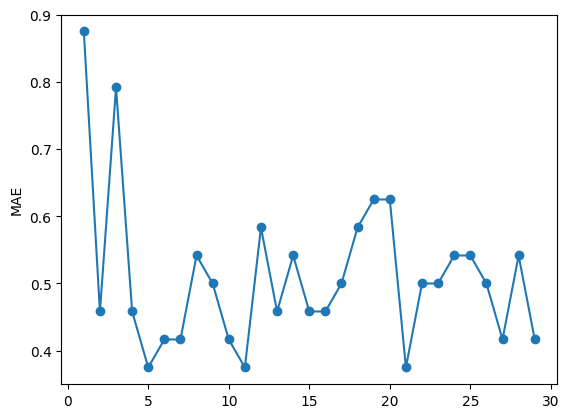

In [ ]:
find_best_max_depth(x_train, y_train, x_test, y_test)

Se entrena el modelo con los datos de entrenamiento y una profundidad máxima de 5.

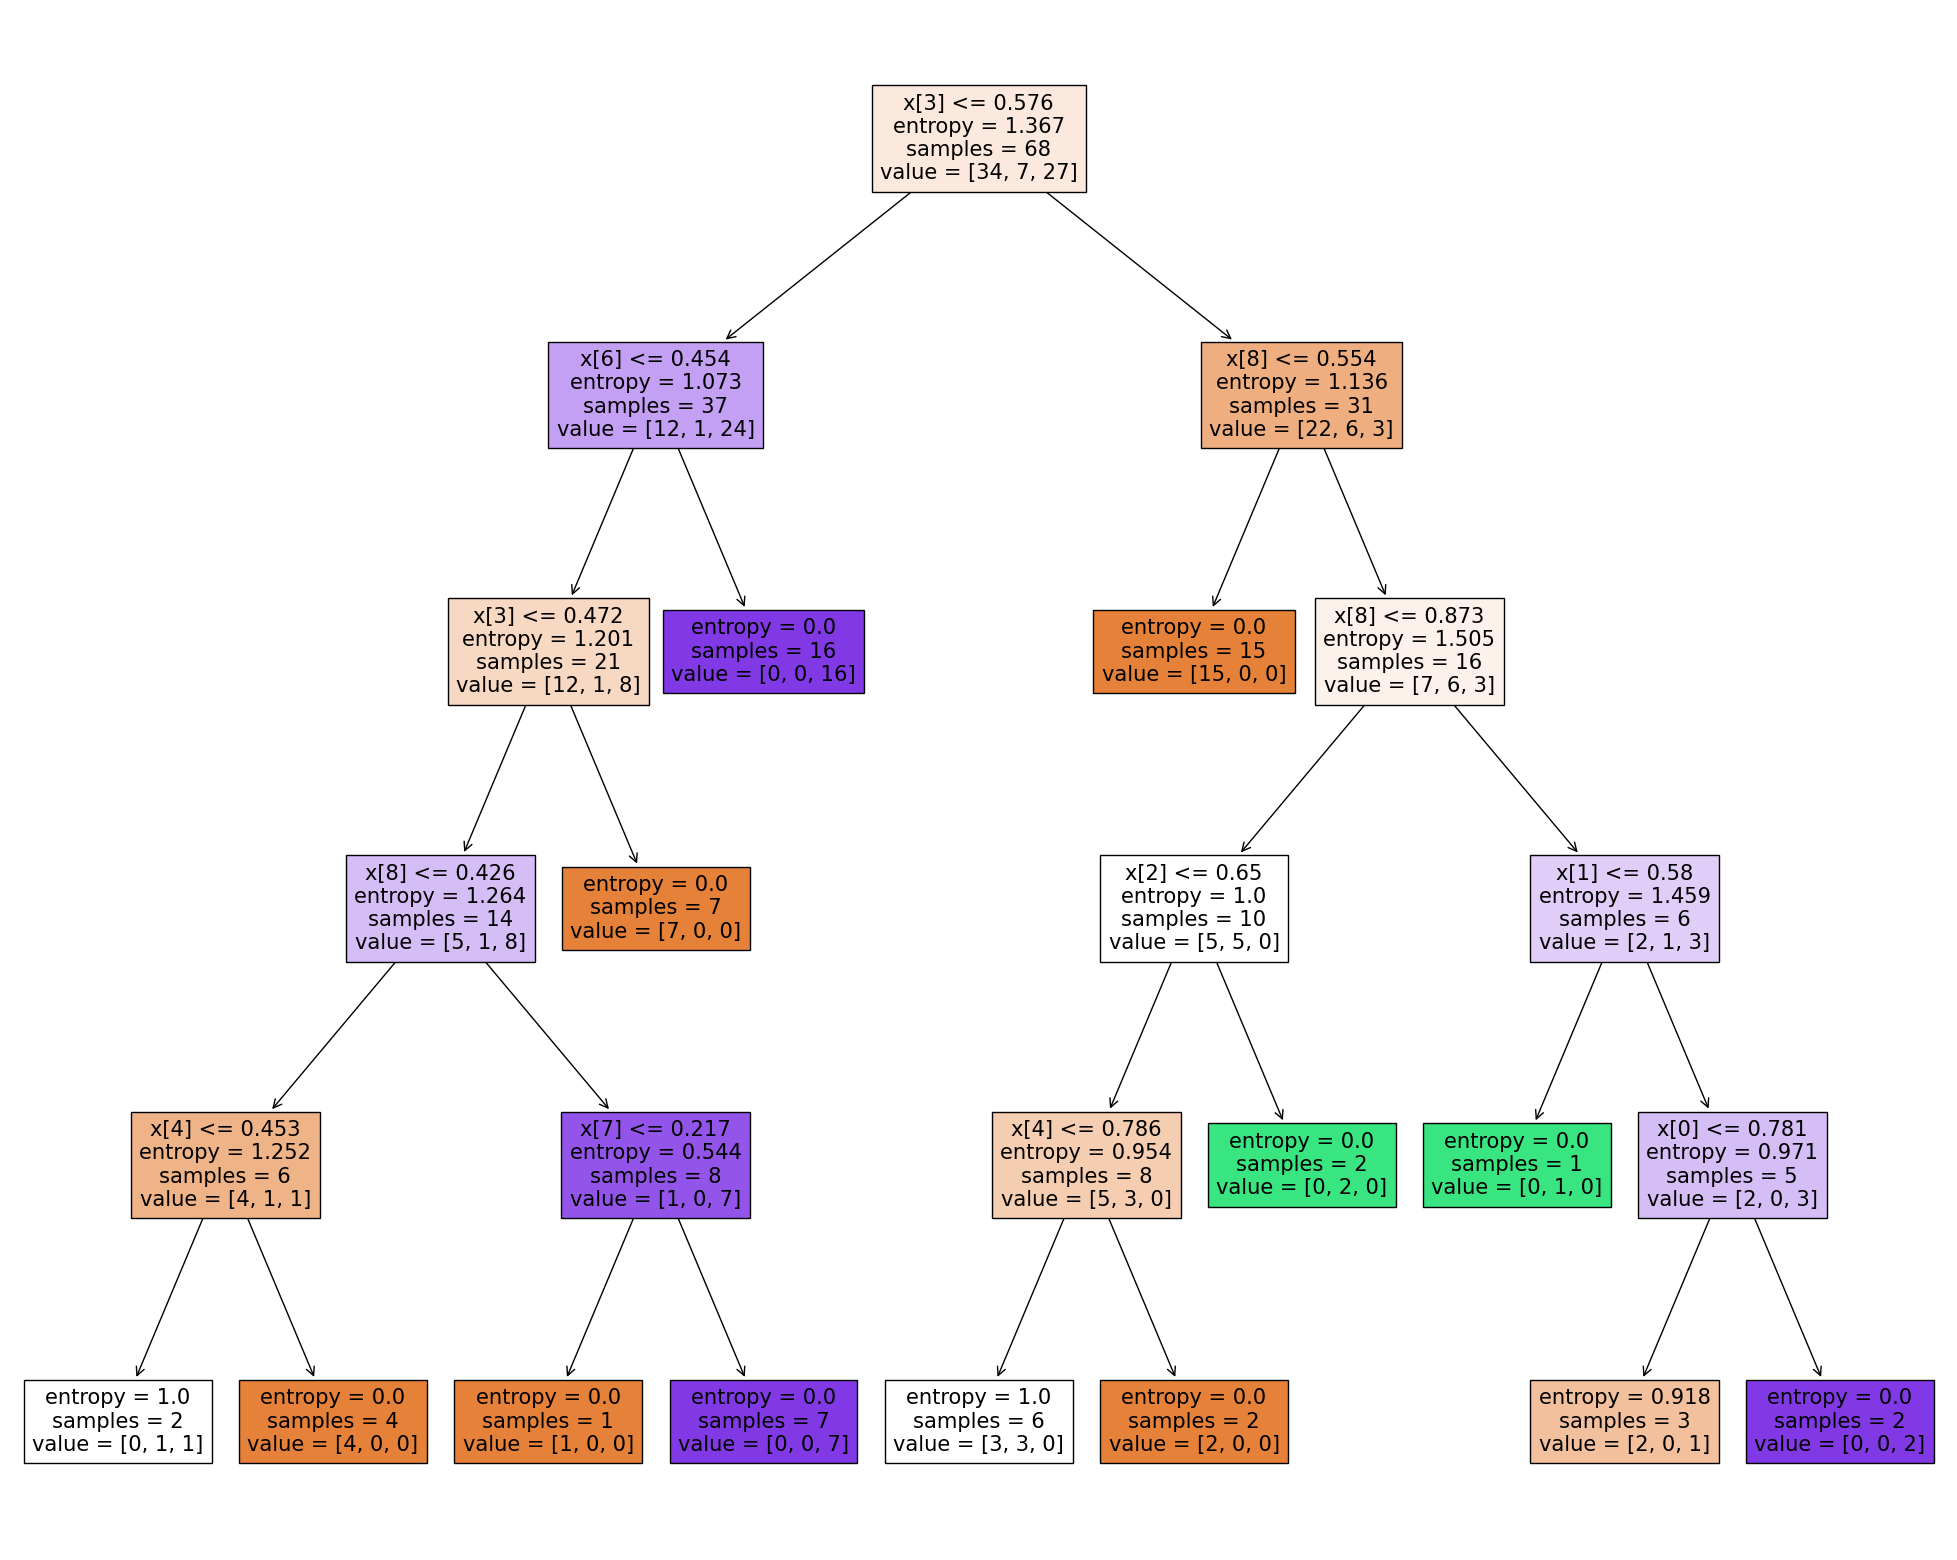

In [ ]:
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5)

decision_tree.fit(x_train, y_train)

fig = plt.figure(figsize=(25,20))
_ = plot_tree(decision_tree, filled=True)

In [ ]:
score = decision_tree.score(x_test, y_test)

print('Precisión del modelo: {:.2f}%'.format(score * 100))

Precisión del modelo: 62.50%


En los resultados podemos apreciar que se distinguen 5 posibles estados. Ligera ventaja para el local o para el visitante, que se identifica dándole 2/3 de posibilidad de victoria, clara ventaja para el local o el visitante, que se identifica dándole el 100% de las probabilidades de victoria (lo cual no es muy realista ya que nunca puede existir la certeza absoluta de que un equipo va a ganar), y el empate, que se identifica dándole un 100% de probabilidades al empate (otro escenario bastante erróneo e incluso más improbable que el anterior).

In [ ]:
predict_results(df_stats_selecciones_normalized, decision_tree, False)

El resultado predicho es: [[0.66666667 0.         0.33333333]]
Victoria de ESP: 66.66666666666666%
Empate: 0.0%
Victoria de SWE: 33.33333333333333%

El resultado predicho es: [[0. 1. 0.]]
Victoria de HUN: 0.0%
Empate: 100.0%
Victoria de DEN: 0.0%

El resultado predicho es: [[0.66666667 0.         0.33333333]]
Victoria de DEN: 66.66666666666666%
Empate: 0.0%
Victoria de FRA: 33.33333333333333%

El resultado predicho es: [[0. 0. 1.]]
Victoria de BRN: 0.0%
Empate: 0.0%
Victoria de BLR: 100.0%

El resultado predicho es: [[1. 0. 0.]]
Victoria de ISL: 100.0%
Empate: 0.0%
Victoria de CRO: 0.0%


#Modelo de Red Neuronal

Se genera y compila la red neuronal con las capas necesarias.

In [ ]:
neural_network = Sequential()
neural_network.add(Dense(128, activation='relu', input_dim=x_train.shape[1]))
neural_network.add(Dense(64, activation='relu'))
neural_network.add(Dropout(0.5))
neural_network.add(Dense(32, activation='relu'))
neural_network.add(Dropout(0.5))
neural_network.add(Dense(16, activation='relu'))
neural_network.add(Dropout(0.5))
neural_network.add(Dense(3, activation='softmax'))

neural_network.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Se entrena el modelo de red neuronal con los datos de entrenamiento.

In [ ]:
y_train_RN = to_categorical(y_train)
y_test_RN = to_categorical(y_test)
neural_network.fit(x_train, y_train_RN, epochs=20, batch_size=32, validation_split=0.2)

score = neural_network.evaluate(x_test, y_test_RN, batch_size=32)

print('Precisión de la red neuronal: {:.2f}%'.format(score[1] * 100))

Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 1.0712 - accuracy: 0.4259 - val_loss: 1.0717 - val_accuracy: 0.4286
Epoch 2/20
2/2 [==============================] - 0s 137ms/step - loss: 1.0720 - accuracy: 0.4259 - val_loss: 1.0676 - val_accuracy: 0.4286
Epoch 3/20
2/2 [==============================] - 0s 125ms/step - loss: 1.0741 - accuracy: 0.4259 - val_loss: 1.0681 - val_accuracy: 0.4286
Epoch 4/20
2/2 [==============================] - 0s 120ms/step - loss: 1.0429 - accuracy: 0.3889 - val_loss: 1.0680 - val_accuracy: 0.4286
Epoch 5/20
2/2 [==============================] - 0s 128ms/step - loss: 1.0277 - accuracy: 0.4630 - val_loss: 1.0681 - val_accuracy: 0.4286
Epoch 6/20
2/2 [==============================] - 0s 119ms/step - loss: 1.0509 - accuracy: 0.5926 - val_loss: 1.0665 - val_accuracy: 0.4286
Epoch 7/20
2/2 [==============================] - 0s 128ms/step - loss: 0.9963 - accuracy: 0.5926 - val_loss: 1.0633 - val_accuracy: 0.4286
Epoch 8/20
2/2 [=======

Todos los resultados tienen sentido, ya que encuentra gran igualdad entre selecciones muy parejas, salvo el de Islandia-Croacia, en el cual se otorga más de la mitad de probabilidad de victoria a Islandia, cuando su mundial fue ligeramente peor al de Croacia. La justificación a este comportamiento es la falta de un partido de Crocia que ganó claramente a Bahrein y que provoca que sus datos globales sean peores.

In [ ]:
predict_results(df_stats_selecciones_normalized, neural_network, True)

1/1 [==============================] - 0s 129ms/step
El resultado predicho es: [[0.39899647 0.20797901 0.3930245 ]]
Victoria de ESP: 39.89964723587036%
Empate: 20.79790085554123%
Victoria de SWE: 39.30245041847229%

1/1 [==============================] - 0s 26ms/step
El resultado predicho es: [[0.32585678 0.24945858 0.42468464]]
Victoria de HUN: 32.58567750453949%
Empate: 24.945858120918274%
Victoria de DEN: 42.468464374542236%

1/1 [==============================] - 0s 23ms/step
El resultado predicho es: [[0.4583519  0.17450836 0.36713973]]
Victoria de DEN: 45.83519101142883%
Empate: 17.450836300849915%
Victoria de FRA: 36.71397268772125%

1/1 [==============================] - 0s 23ms/step
El resultado predicho es: [[0.34343535 0.25971207 0.39685258]]
Victoria de BRN: 34.34353470802307%
Empate: 25.97120702266693%
Victoria de BLR: 39.68525826931%

1/1 [==============================] - 0s 26ms/step
El resultado predicho es: [[0.50822186 0.17987274 0.3119054 ]]
Victoria de ISL: 50.8221

#Modelo de SVM (Support Vector Machine)

Se emplea la búsqueda en cuadrícula para obtener los parámetros óptimos de SVM.

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid = {'C': C_values}
svm_prueba = svm.SVC(kernel='linear')
grid_search = GridSearchCV(svm_prueba, param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train, y_train)

best_C = grid_search.best_params_['C']
print(f"El mejor valor para C es: {best_C}")

El mejor valor para C es: 1


Se genera el modelo de SVM con los mejores parámetros encontrados y se entrena con los datos de entrenamiento.

In [ ]:
svm_model = svm.SVC(kernel='linear', C=best_C, probability=True)

svm_model.fit(x_train, y_train)

y_pred_SVM = svm_model.predict(x_test)

print(classification_report(y_test, y_pred_SVM))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.00      0.00      0.00         3
           2       0.88      1.00      0.93         7

    accuracy                           0.88        24
   macro avg       0.58      0.67      0.62        24
weighted avg       0.77      0.88      0.82        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos destacar que los resultados son menos parejos entre selecciones igualadas, lo cual podría indicar cierto *overfitting* en nuestros resultados. Aparte, este modelo da como favorita a Suecia en vez de a España en el primer encuentro a pronosticar, al contrario que en el anterior algoritmo, y da un favoritismo incluso mayor a Islandia en un duelo contra Croacia en el que no debería ser favorita. De hecho, en el año 2022 se enfrentaron en el Europeo de balonmano, y la ganadora del duelo fue Croacia (históricamente se han enfrentado 10 veces e Islandia nunca ha conseguido derrotar a Croacia).

In [ ]:
predict_results(df_stats_selecciones_normalized, svm_model, False)

El resultado predicho es: [[0.35896241 0.16351458 0.47752301]]
Victoria de ESP: 35.8962410124381%
Empate: 16.35145756286571%
Victoria de SWE: 47.7523014246962%

El resultado predicho es: [[0.07666137 0.09889679 0.82444184]]
Victoria de HUN: 7.666137335427996%
Empate: 9.889678558915477%
Victoria de DEN: 82.44418410565652%

El resultado predicho es: [[0.61877502 0.15173627 0.22948871]]
Victoria de DEN: 61.877502391287855%
Empate: 15.173626856403644%
Victoria de FRA: 22.948870752308505%

El resultado predicho es: [[0.1808629  0.08627088 0.73286621]]
Victoria de BRN: 18.086290341305343%
Empate: 8.627088174009861%
Victoria de BLR: 73.28662148468482%

El resultado predicho es: [[0.65650019 0.13518692 0.20831289]]
Victoria de ISL: 65.65001900018379%
Empate: 13.518692491985398%
Victoria de CRO: 20.831288507830795%


#Modelo de Random Forest (Ensembled)

Se emplea la búsqueda en cuadrícula para obtener los parámetros óptimos de Random Forest.

In [ ]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1)
grid_search.fit(x_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


Se genera el modelo de Random Forest, se entrena con los datos de entrenamiento y se evalúa su precisión obtenida con los datos de test.

In [ ]:
best_rf = grid_search.best_estimator_
y_pred_RF = best_rf.predict(x_test)

print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        14
           1       0.00      0.00      0.00         3
           2       0.86      0.86      0.86         7

    accuracy                           0.83        24
   macro avg       0.56      0.62      0.59        24
weighted avg       0.73      0.83      0.78        24



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Estos resultados se ajustan mucho al bajo número de empates, y por eso dan tan bajas probabilidades de empates en casi todos los partidos, aunque muestren igualdad a la hora de predecir si el equipo local o visitante es el favorito (exceptuando el segundo y los últimos dos partidos).

In [ ]:
predict_results(df_stats_selecciones_normalized, best_rf, False)

El resultado predicho es: [[0.44943889 0.16984762 0.38071349]]
Victoria de ESP: 44.94388888888889%
Empate: 16.984761904761896%
Victoria de SWE: 38.07134920634921%

El resultado predicho es: [[0.18750238 0.23120794 0.58128968]]
Victoria de HUN: 18.750238095238085%
Empate: 23.120793650793654%
Victoria de DEN: 58.12896825396824%

El resultado predicho es: [[0.42893492 0.15207222 0.41899286]]
Victoria de DEN: 42.893492063492076%
Empate: 15.207222222222223%
Victoria de FRA: 41.899285714285725%

El resultado predicho es: [[0.10941429 0.03792857 0.85265714]]
Victoria de BRN: 10.941428571428574%
Empate: 3.7928571428571423%
Victoria de BLR: 85.2657142857143%

El resultado predicho es: [[0.78407619 0.09774762 0.11817619]]
Victoria de ISL: 78.40761904761906%
Empate: 9.774761904761908%
Victoria de CRO: 11.81761904761905%


#Modelo de KNN

Se busca, mediante validación cruzada, la distancia y el número de vecinos óptima para obtener el mínimo MAE.

Manhattan Distance

Min Value uniform : 0.125 (8)
Min Value distance : 0.125 (8)


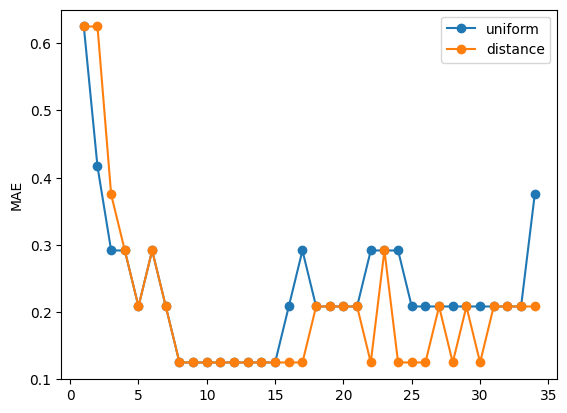

Euclidean Distance

Min Value uniform : 0.125 (7)
Min Value distance : 0.125 (8)


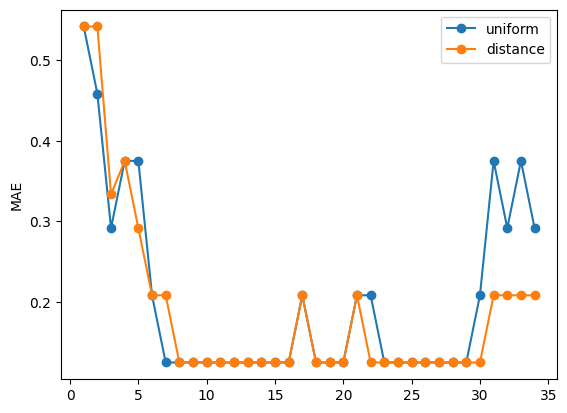

In [ ]:
find_best_parameters_KNN(x_train, y_train, x_test, y_test)

Se genera el modelo con los mejores parámetros obtenidos en la celda anterior y se evalúa con los datos de test.

In [ ]:
n_neighbors = 3
weights = 'uniform'
knn = neighbors.KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights, p=1) 

knn.fit( X = x_train, y = y_train)
y_pred = knn.predict(X = x_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)

MAE 0.2916666666666667


In [ ]:
score = knn.score(x_test, y_test)

print('Precisión del modelo: {:.2f}%'.format(score * 100))

Precisión del modelo: 79.17%


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


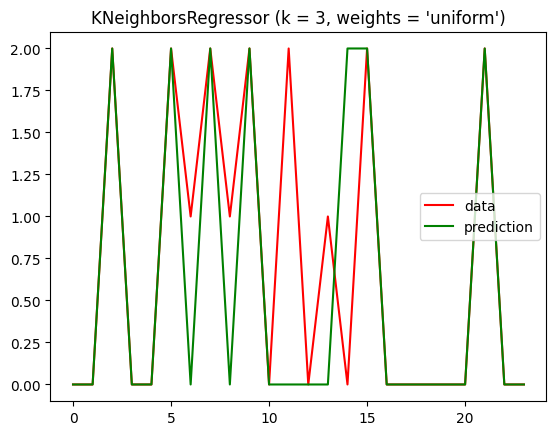

In [ ]:
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

Parecido al Decision Tree, en cuanto a que da 2/3 a la opción que encuentra ligeramente más probable o 100% si la encuentra totalmente probable, en una comparación directa con este algoritmo da resultados ligeramente más creibles, como el favoritismo de Suecia y Dinamarca, o el no favoritismo absoluto de Islancia ante Croacia, aunque siga dando resultados erróneos como el 100% de probabilidades de victoria de Bielorrusia.

In [ ]:
predict_results(df_stats_selecciones_normalized, knn, False)

El resultado predicho es: [[0.33333333 0.         0.66666667]]
Victoria de ESP: 33.33333333333333%
Empate: 0.0%
Victoria de SWE: 66.66666666666666%

El resultado predicho es: [[0.         0.33333333 0.66666667]]
Victoria de HUN: 0.0%
Empate: 33.33333333333333%
Victoria de DEN: 66.66666666666666%

El resultado predicho es: [[0.66666667 0.         0.33333333]]
Victoria de DEN: 66.66666666666666%
Empate: 0.0%
Victoria de FRA: 33.33333333333333%

El resultado predicho es: [[0. 0. 1.]]
Victoria de BRN: 0.0%
Empate: 0.0%
Victoria de BLR: 100.0%

El resultado predicho es: [[0.66666667 0.33333333 0.        ]]
Victoria de ISL: 66.66666666666666%
Empate: 33.33333333333333%
Victoria de CRO: 0.0%
